In [1]:
%matplotlib widget

In [2]:
import flammkuchen as fl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import imageio
from scipy.stats import sem
import seaborn as sns
from bouter.free import FreelySwimmingExperiment
import pandas as pd
from scipy import signal
from tqdm import tqdm
from scipy.stats import zscore
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity as kde
from scipy.stats import linregress
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu, ttest_1samp
import random

In [3]:
def sidak(α,m):
    return α*(α / (1-(1-0.05)**(1/m)))
def clip(x_):
    x_[x_>200]=200
    x_[x_<0]= 0
    return x_
def clean_augment(x_,stim_fun,setpoint):
    out_ = []
    for df_ in x_:
        if "flip_x_start" in df_.keys():
            pass
        else:
            df_["flip_x_start"] = df_["al_start_x"]
            df_["flip_y_start"] = df_["al_start_y"]
            
            df_["flip_x_end"] = df_["al_end_x"]
            df_["flip_y_end"] = df_["al_end_y"]
        df_["flip_x_start"] = clip(df_["flip_x_start"].values)
        try:
            df_["flip_x_end"] = clip(df_["flip_x_end"].values)
        except:
            df_["flip_x_end"] = clip(df_["al_end_x"].values)
        out_.append(augment(df_,stim_fun,setpoint))
    return out_

def clean_augment_cpca(x_,stim_fun,setpoint):
    out_ = []
    for df_ in x_:
        df_["flip_x_start"] = abs(200-clip(df_["flip_x_start"].values))
        out_.append(augment(df_,stim_fun,setpoint))
    return out_

def dist_setpoint(values,setpoint):
    return abs(values - setpoint)

def augment(bout_properties,fun,setpoint,time_th=2):
    border_x = [10, 190]
    border_y = [5, 45]
    x_start = []
    x_end = []
    temp_start = []
    temp_end = []
    temp_pre = []
    delta = []
    delta_prev = []
    out = []
    prev_biases = []
    temporal_distance = []
    prev_bout = None
    prev_bias = None
    prev_temp = None
    delta_prev_prev_bout = None
    delta_prev_bout = np.nan
    for i in range(len(bout_properties)):
        
        bout = bout_properties.iloc[i]
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if (temporal_distance <= time_th)& (delta_prev_bout!=np.nan):
                delta_prev_prev_bout = delta_prev_bout
            else:
                delta_prev_prev_bout  = np.nan
                
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if temporal_distance <= time_th:
                prev_bias = prev_bout["theta_bout"]
                
                delta_prev_bout = dist_setpoint(float(fun(prev_bout["flip_x_start"])),setpoint) - dist_setpoint(float(fun(bout["flip_x_start"])),setpoint)
                prev_temp = dist_setpoint(float(fun(prev_bout["flip_x_start"])),setpoint)
            else:
                delta_prev_bout  = np.nan
                prev_bias = np.nan
                prev_temp = np.nan
            
        temp_start.append(dist_setpoint(float(fun(bout["flip_x_start"])),setpoint))
        delta.append(delta_prev_bout)
        delta_prev.append(delta_prev_prev_bout)
        x_start.append(bout['flip_x_start'])
        temp_pre.append(prev_temp)
        prev_biases.append(prev_bias)
        if (border_x[0] <= bout["flip_x_start"] <= border_x[1]) and (border_y[0] <= bout["y_start"] <= border_y[1]):
            is_out = False
        else:
            is_out = True
        out.append(is_out)
        prev_bout = bout.copy()
    bout_properties["temp_start"] = temp_start
    bout_properties["delta"]=delta
    bout_properties["delta_1"]=delta_prev
    bout_properties["out"]=out
    bout_properties["prev_bias"]=prev_biases
    bout_properties["prev_temp"] = temp_pre
    return bout_properties

def prefered_temperature(x_position,times,resolution=2):
    result = medfilt(np.interp(np.linspace(0,15*60,15*60*resolution),
            times,x_position),3)
    return np.nanmedian(result[600*resolution:])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 

In [4]:
plt.rcParams.update({'font.size': 25})

In [5]:
setpoint_wt = 25.280104571722397
setpoint_hb = 27.89187878451635
setpoint_abl = 27.181914005550055

In [7]:
full_dataset = fl.load(r"Z:\experiments\virtual_gradients_experiments\freely_swim_Ruben\data.h5")

transfer_fun = interp1d(full_dataset["stimulus_calibration"][0,:],
                             full_dataset["stimulus_calibration"][1,:],
                             kind="quadratic")
WT = clean_augment(full_dataset["WT"].copy(),transfer_fun,setpoint_wt)
Hbpos_pre = clean_augment(full_dataset["Hbpos_pre_ablation"].copy(),transfer_fun,setpoint_hb)
Hbneg_post = clean_augment(full_dataset["Hbneg_post_ablation"].copy(),transfer_fun,setpoint_hb)
Hbpos_post = clean_augment(full_dataset["Hbpos_ablation"].copy(),transfer_fun,setpoint_hb)

In [8]:
twopabl_dataset = fl.load(r"Z:\experiments\virtual_gradients_experiments\data_2p_ablations.h5")
poa_abl = clean_augment(twopabl_dataset["poa"].copy(),transfer_fun,setpoint_abl)
ot_abl = clean_augment(twopabl_dataset["ot"].copy(),transfer_fun,setpoint_abl)

## Distance

In [144]:
bins_theta = np.linspace(0,5,21)
hists = []
for fish_ in WT:
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values>=0.1333)]["distance"])
    c,_ = np.histogram(bouts_in_bin,bins_theta)
    c = c / np.sum(c)
    
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values<=-0.1333)]["distance"])
    c0,_ = np.histogram(bouts_in_bin,bins_theta)
    c0 = c0 / np.sum(c0)
    
    hists.append(np.array([c,c0]))
hists = np.stack(hists)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [76]:
colors = ["#8e530b","#036860"]

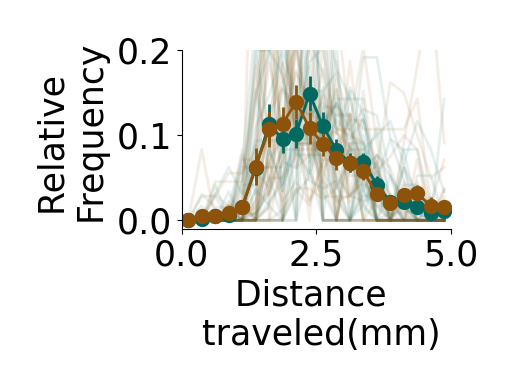

In [145]:
bins_center = (bins_theta[1:]+bins_theta[:-1])/2
plt.figure()

plt.plot(bins_center,hists[:,0,:].T,lw=2,color=colors[-1],alpha=.1)

plt.plot(bins_center,hists[:,1,:].T,lw=2,color=colors[0],alpha=.1)

plt.errorbar(bins_center,np.nanmean(hists[:,0,:],0),
             yerr=sem(hists[:,0,:],0,nan_policy="omit"),
            lw=2,fmt="-",ms=6,marker="o",mew=5,c=colors[1],
            capthick=5)

plt.errorbar(bins_center,np.nanmean(hists[:,1,:],0),
             yerr=sem(hists[:,-1,:],0,nan_policy="omit"),
            lw=2,fmt="-",ms=6,marker="o",mew=5,c=colors[0],
            capthick=5)

# plt.text(bins_center[0]-.04,0.8,"*",color="k",fontsize=40,fontweight="bold")
# plt.text(bins_center[1]-.04,0.35,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Relative \n Frequency",fontsize=25)
plt.xlabel("Distance \n traveled(mm)",fontsize=25)
plt.yticks([0,.1,.2],fontsize=25)
plt.ylim([-.01,.2])
plt.xlim(bins_theta[0],bins_theta[-1])
plt.xticks([0,2.5,5],fontsize=25)
set_size(4,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point2_1_distance.png",dpi=800)

In [89]:
for i in range(hists.shape[-1]):
    
    print(mannwhitneyu(hists[np.isfinite(hists[:,0,i]),0,i],
                       hists[np.isfinite(hists[:,1,i]),1,i])[1])

1.0
0.24698512315391763
0.5785775184365685
0.33434705035107837
0.9729730151055823
0.4911104896751878
0.7411246165998079
0.5266445993085375
0.08059890302722406
0.09903314142349226
0.3216866467474724
0.47492227856724223
0.9921888585276293
0.4595628622286737
0.5451959724670039
0.7952374768451612
0.557638503081954
0.174814211494147
0.685935263911504
0.31714279556842473


In [94]:
th_min_bouts = 5
iso_th = 0.1333
delta_bins = np.array([-3,-iso_th,iso_th,3])
turn_index = []
for fish_ in WT:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [np.nanmedian(bouts_in_bin["distance"].values)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index.append(fish_vect-np.array(fish_vect[-1]))
turn_index = np.array(turn_index)
print(mannwhitneyu(turn_index[np.isfinite(turn_index[:,0,0]),0,0],
                   turn_index[np.isfinite(turn_index[:,-1,0]),-1,0])[1])

1.0


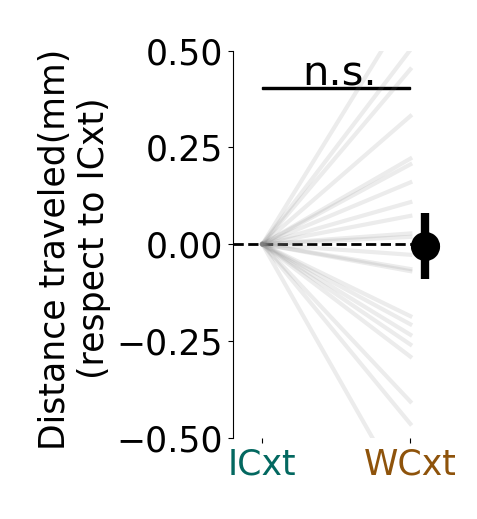

In [107]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,1.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index.shape[0]),turn_index[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index[:,0,0],0),
             yerr=sem(turn_index[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="k",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.27,0.41,"n.s.",color="k",fontsize=30)

plt.ylabel("Distance traveled(mm) \n (respect to ICxt)",fontsize=25)
plt.xticks([0,1],["ICxt","WCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]):
    ticklabel.set_color(tickcolor)
plt.ylim([-.5,.5])
plt.yticks([-.5,-.25,0,.25,.5],fontsize=25)
plt.xlim([-.2,1.2])
sns.despine(bottom=True)
set_size(3.7,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point2_0_distance.png",dpi=800)

## Bout duration

In [146]:
bins_theta = np.linspace(0,.6,21)
hists = []
for fish_ in WT:
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values>=0.1333)]["bout_duration"])
    c,_ = np.histogram(bouts_in_bin,bins_theta)
    c = c / np.sum(c)
    
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values<=-0.1333)]["bout_duration"])
    c0,_ = np.histogram(bouts_in_bin,bins_theta)
    c0 = c0 / np.sum(c0)
    
    hists.append(np.array([c,c0]))
hists = np.stack(hists)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


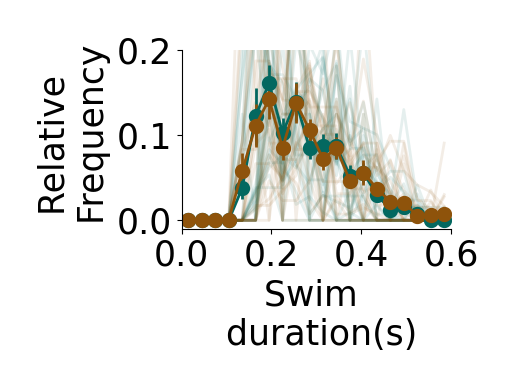

In [148]:
bins_center = (bins_theta[1:]+bins_theta[:-1])/2
plt.figure()

plt.plot(bins_center,hists[:,0,:].T,lw=2,color=colors[-1],alpha=.1)

plt.plot(bins_center,hists[:,1,:].T,lw=2,color=colors[0],alpha=.1)

plt.errorbar(bins_center,np.nanmean(hists[:,0,:],0),
             yerr=sem(hists[:,0,:],0,nan_policy="omit"),
            lw=2,fmt="-",ms=6,marker="o",mew=5,c=colors[1],
            capthick=5)

plt.errorbar(bins_center,np.nanmean(hists[:,1,:],0),
             yerr=sem(hists[:,-1,:],0,nan_policy="omit"),
            lw=2,fmt="-",ms=6,marker="o",mew=5,c=colors[0],
            capthick=5)

# plt.text(bins_center[0]-.04,0.8,"*",color="k",fontsize=40,fontweight="bold")
# plt.text(bins_center[1]-.04,0.35,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Relative \n Frequency",fontsize=25)
plt.xlabel("Swim \n duration(s)",fontsize=25)
plt.yticks([0,.1,.2],fontsize=25)
plt.ylim([-.01,.2])
plt.xlim(bins_theta[0],bins_theta[-1])
plt.xticks([0,.2,.4,.6],fontsize=25)
set_size(4,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point2_3_duration.png",dpi=800)

In [149]:
th_min_bouts = 5
iso_th = 0.1333
delta_bins = np.array([-3,-iso_th,iso_th,3])
turn_index = []
for fish_ in WT:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [np.nanmedian(bouts_in_bin["bout_duration"].values)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index.append(fish_vect-np.array(fish_vect[-1]))
turn_index = np.array(turn_index)
print(mannwhitneyu(turn_index[np.isfinite(turn_index[:,0,0]),0,0],
                   turn_index[np.isfinite(turn_index[:,-1,0]),-1,0])[1])

0.5895791031218676


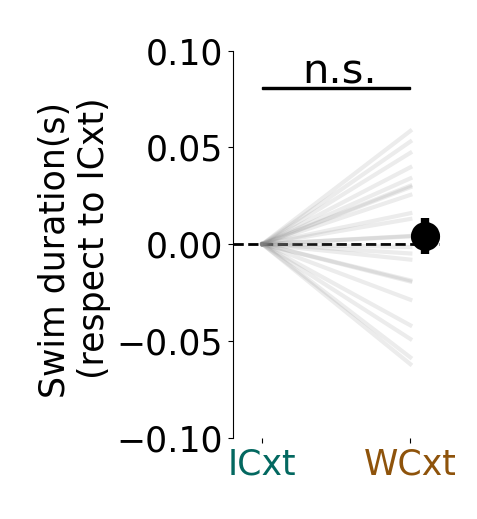

In [158]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,1.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index.shape[0]),turn_index[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index[:,0,0],0),
             yerr=sem(turn_index[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="k",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.27,0.083,"n.s.",color="k",fontsize=30)

plt.ylabel("Swim duration(s) \n (respect to ICxt)",fontsize=25)
plt.xticks([0,1],["ICxt","WCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]):
    ticklabel.set_color(tickcolor)
plt.ylim([-.1,.1])
plt.yticks([-.1,-.05,0,.05,.1],fontsize=25)
plt.xlim([-.2,1.2])
sns.despine(bottom=True)
set_size(3.7,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point2_2_duration.png",dpi=800)

In [163]:
## Interswim interval

In [182]:
bins_theta = np.linspace(0,2.2,21)
hists = []
for fish_ in WT:
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values>=0.1333)]["interbout"])
    c,_ = np.histogram(bouts_in_bin,bins_theta)
    c = c / np.sum(c)
    
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values<=-0.1333)]["interbout"])
    c0,_ = np.histogram(bouts_in_bin,bins_theta)
    c0 = c0 / np.sum(c0)
    
    hists.append(np.array([c,c0]))
hists = np.stack(hists)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


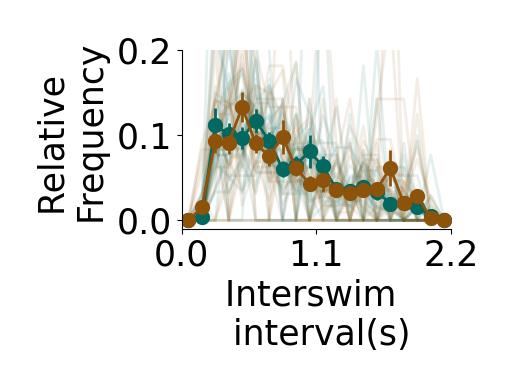

In [186]:
bins_center = (bins_theta[1:]+bins_theta[:-1])/2
plt.figure()

plt.plot(bins_center,hists[:,0,:].T,lw=2,color=colors[-1],alpha=.1)

plt.plot(bins_center,hists[:,1,:].T,lw=2,color=colors[0],alpha=.1)

plt.errorbar(bins_center,np.nanmean(hists[:,0,:],0),
             yerr=sem(hists[:,0,:],0,nan_policy="omit"),
            lw=2,fmt="-",ms=6,marker="o",mew=5,c=colors[1],
            capthick=5)

plt.errorbar(bins_center,np.nanmean(hists[:,1,:],0),
             yerr=sem(hists[:,-1,:],0,nan_policy="omit"),
            lw=2,fmt="-",ms=6,marker="o",mew=5,c=colors[0],
            capthick=5)

# plt.text(bins_center[0]-.04,0.8,"*",color="k",fontsize=40,fontweight="bold")
# plt.text(bins_center[1]-.04,0.35,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Relative \n Frequency",fontsize=25)
plt.xlabel("Interswim \n interval(s)",fontsize=25)
plt.yticks([0,.1,.2],fontsize=25)
plt.ylim([-.01,.2])
plt.xlim(bins_theta[0],bins_theta[-1])
plt.xticks([0,1.1,2.2],fontsize=25)
set_size(4,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point2_4_interswim.png",dpi=800)

In [187]:
th_min_bouts = 5
iso_th = 0.1333
delta_bins = np.array([-3,-iso_th,iso_th,3])
turn_index = []
for fish_ in WT:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [np.nanmedian(bouts_in_bin["interbout"].values)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index.append(fish_vect-np.array(fish_vect[-1]))
turn_index = np.array(turn_index)
print(mannwhitneyu(turn_index[np.isfinite(turn_index[:,0,0]),0,0],
                   turn_index[np.isfinite(turn_index[:,-1,0]),-1,0])[1])

1.0


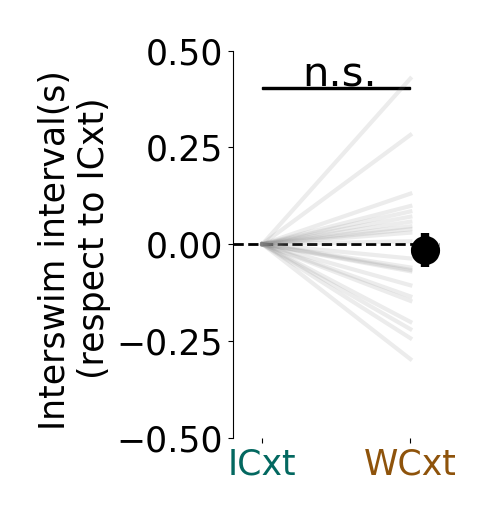

In [195]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,1.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index.shape[0]),turn_index[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index[:,0,0],0),
             yerr=sem(turn_index[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="k",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.27,0.408,"n.s.",color="k",fontsize=30)

plt.ylabel("Interswim interval(s) \n (respect to ICxt)",fontsize=25)
plt.xticks([0,1],["ICxt","WCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]):
    ticklabel.set_color(tickcolor)
plt.ylim([-.5,.5])
plt.yticks([-.5,-.25,0,.25,.5],fontsize=25)
plt.xlim([-.2,1.2])
sns.despine(bottom=True)
set_size(3.7,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point2_3_interswim.png",dpi=800)